原始论文： 波动率与换手率构造牛熊指标

论文解读： [量化-研报复现]探究使用波动率与换手率构造牛熊指标因子

论文简介: 波动率和换手率是常见的市场监测指标，其与市场长期走势明显负相关的指标，而且指标趋势性较好，因此可以用来判断股票市场状况。本文分享的工作借助波动率与换手率构造出的牛熊指标因子，借助牛熊指标因子开发的择时策略普遍优于直接对指数本身的择时策略。

为了进一步拓展波动率和换手率的使用，本人在原研报的基础上进行了扩展，尝试使用OpenFE进行因子的自动生成，结果显示可以进一步提升策略的收益。

作者： Spectator

结构说明：

第一部分: 安装并导入依赖包;
第二部分：加载并预处理数据;
第三部分：使用原始研报中的牛熊指标因子进行回测;
第四部分：使用OpenFE进行自动因子挖掘，并对挖掘出来的因子进行回测。

结果说明：

1.波动率和换手率都是复现的，可能和原文的设置并不完全一致，但是结果和原文结果是一致的。

2.为了处理方便，交易没有考虑手续费，由于交易频率较低，手续费影响有限；

3.原始研报中的牛熊因子和使用OpenFE进行自动因子挖掘都是在数据上直接进行的，存在过拟合失效的风险。

4.使用OpenFE进行因子挖掘是主要为了展示OpenFE的功能，当前的用法存在不合理性。

5.只展示了双均线策略和上证指数的回测结果，可以通过修改指数名称和自定义布林带策略进行回测。

# 第一部分: 安装并导入依赖包

1.安装依赖包

In [ ]:
pip install tushare && pip install pandas && pip install pandas && pip install quantstats && pip install openfe

2.导入依赖包

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import time 
import math
import tushare
import pandas as pd
import numpy as np
import quantstats as qs
qs.extend_pandas()
import matplotlib.pyplot as plt
%matplotlib inline

from openfe import openfe, transform

# 第二部分：加载数据

3.定义使用tushare的数据加载函数，使用tushare需要注册账户并配置token（没有账户或账户积分不足可以使用离线数据运行）

In [2]:
token = "tuhsare账户的token"
tushare.set_token(token)
ts = tushare.pro_api()

def fetch_index_data(ts_code, **kwargs):
    start_date = kwargs.get("start",None)
    end_date = kwargs.get("end",None)
    datas = []
    while True:
        index_dailybasic_data = ts.index_dailybasic(ts_code=ts_code,end_date=end_date).iloc[::-1]
        index_daily_data = ts.index_daily(ts_code=ts_code,end_date=end_date).iloc[::-1]
        data = index_dailybasic_data.merge(index_daily_data, on=['trade_date','ts_code'])
        current_start_date = data.iloc[0]["trade_date"]
        if current_start_date == start_date:
            break
        else:
            start_date = current_start_date
            end_date = current_start_date
        datas.append(data)
        time.sleep(0.01)
    datas = datas[::-1]
    data = pd.concat(datas)
    data.drop_duplicates(inplace=True)
    data = data.reset_index(drop=True)

    data = data.rename(columns={"ts_code" : "code", "trade_date": "date"})
    data = data.set_index("date")
    data.index = pd.to_datetime(data.index)

    return data

4.加载数据

In [3]:
# 上证综指
ts_code = "000001.SH"
# 沪深300
#ts_code = "000300.SH"

try:
    data = fetch_index_data(ts_code)[["close", "turnover_rate_f","pct_chg"]]
    data.to_csv(ts_code+".csv")
except:
    data = pd.read_csv(ts_code+".csv")
    data = data.set_index("date")
data["turnover_rate_f"] *= 0.01
data["day_return"] = data.close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])

5.计算250天的波动率方差和换手率均值

In [4]:
data["day_return"] = data.close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
data["rolling_volatility"] = data.get("close").pct_change().rolling(250,min_periods=100).std()
data["rolling_turnover_rate"] = data.get("turnover_rate_f").rolling(250,min_periods=100).mean()

# 三 使用牛熊指标进行回测
6.计算牛熊指标，并使用双均线策略进行回测

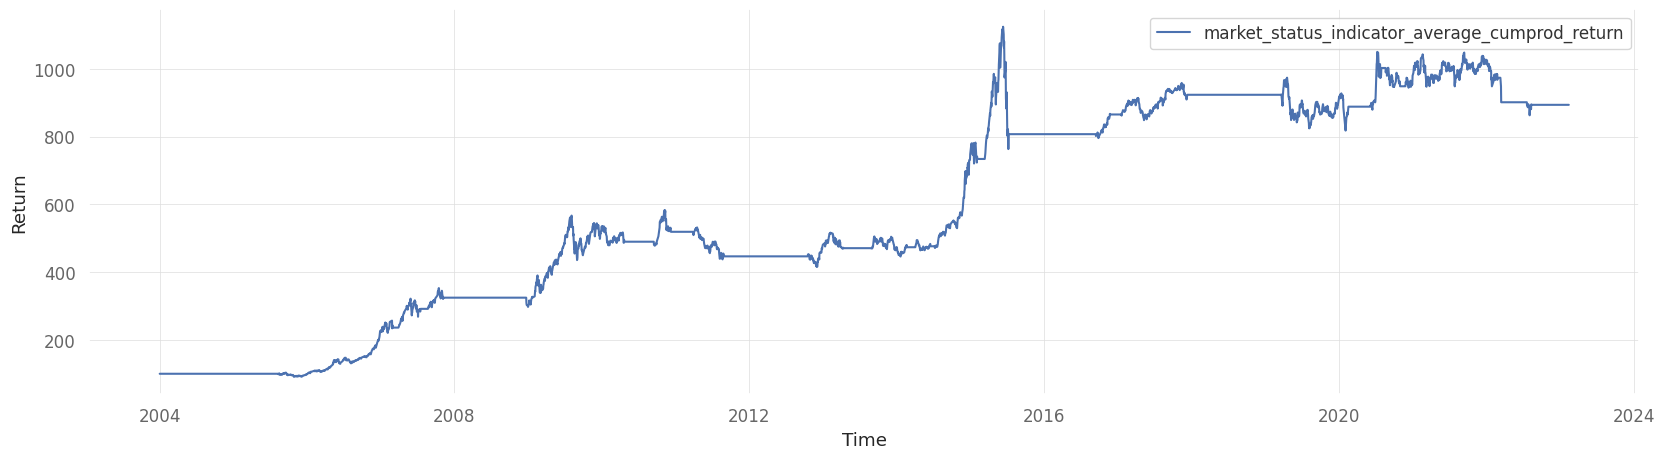

In [5]:
data["market_status_indicator"] = data["rolling_volatility"]/data["rolling_turnover_rate"]
data["market_status_indicator_20day_average"] = data.get("market_status_indicator").rolling(20).mean()
data["market_status_indicator_60day_average"] = data.get("market_status_indicator").rolling(60).mean()

data["market_status_indicator_average_flag"] = (data["market_status_indicator_20day_average"] <= data["market_status_indicator_60day_average"]).astype(int)
# 指标后移一个时间单位，和下一个时间单位对齐（上一时刻计算出的指标用于指示当前时刻的操作）
data["market_status_indicator_average_flag"].iloc[1:] = data["market_status_indicator_average_flag"].iloc[:-1] 
data["market_status_indicator_average_return"] = data.market_status_indicator_average_flag * data.day_return
data["market_status_indicator_average_cumprod_return"] = np.cumprod(data["market_status_indicator_average_return"].fillna(0).values + 1) *100

_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('Return')
_ = plt.plot(data["market_status_indicator_average_cumprod_return"])
_ = plt.legend(['market_status_indicator_average_cumprod_return',]) 


# 四 使用OpenFE进行自动因子挖掘

7.使用rolling_volatility和rolling_turnover_rate作为特征，使用OpenFE挖掘高级特征

In [6]:
ofe = openfe()
train_x = data[["rolling_volatility","rolling_turnover_rate"]]
train_y = data.close
features = ofe.fit(data=train_x, label=train_y, n_jobs=16)  # generate new features
print(f"第一个特征的算子名称{features[0].name} ; 第一特征的输入数据：{[children.name for children in features[0].children]}")

The number of candidate features is 22
Start stage I selection.


100%|██████████| 22/22 [00:00<00:00, 38.93it/s]


13 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


100%|██████████| 9/9 [00:00<00:00, 23.02it/s]


The number of remaining candidate features is 9
Start stage II selection.
Finish data processing.
第一个特征的算子名称- ; 第一特征的输入数据：['rolling_volatility', 'rolling_turnover_rate']


8.按照7的挖掘结果生成挖掘出来的第一个特征数据

In [7]:
data["market_status_indicator_openfe"] = data["rolling_volatility"] - data["rolling_turnover_rate"]

9.使用6中的双均线策略对挖掘出的特征进行回测，并和原始研报中的牛熊指标进行对比

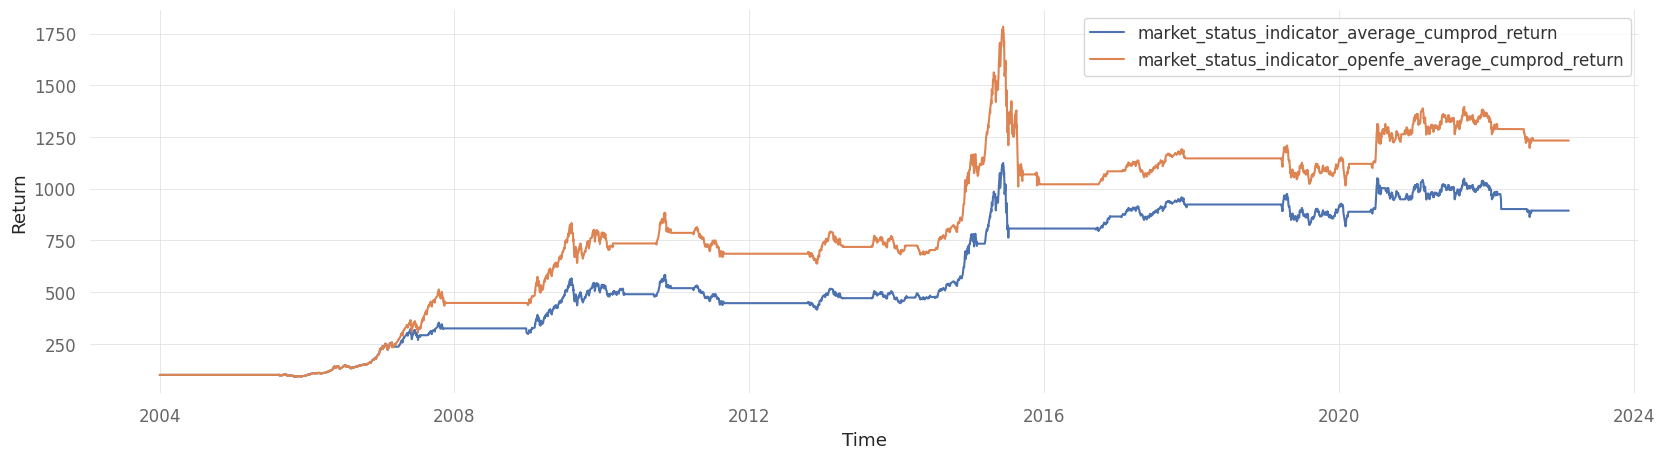

In [8]:
data["market_status_indicator_openfe_20day_average"] = data.get("market_status_indicator_openfe").rolling(20).mean()
data["market_status_indicator_openfe_60day_average"] = data.get("market_status_indicator_openfe").rolling(60).mean()

data["market_status_indicator_openfe_average_flag"] = (data["market_status_indicator_openfe_20day_average"] <= data["market_status_indicator_openfe_60day_average"]).astype(int)
# 指标后移一个时间单位，和下一个时间单位对齐（上一时刻计算出的指标用于指示当前时刻的操作）
data["market_status_indicator_openfe_average_flag"].iloc[1:] = data["market_status_indicator_openfe_average_flag"].iloc[:-1] 
data["market_status_indicator_openfe_average_return"] = data.market_status_indicator_openfe_average_flag * data.day_return
data["market_status_indicator_openfe_average_cumprod_return"] = np.cumprod(data["market_status_indicator_openfe_average_return"].fillna(0).values + 1) *100

_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('Return')
_ = plt.plot(data["market_status_indicator_average_cumprod_return"])
_ = plt.plot(data["market_status_indicator_openfe_average_cumprod_return"])
_ = plt.legend(['market_status_indicator_average_cumprod_return', 'market_status_indicator_openfe_average_cumprod_return'])
